# Контролируемая генерация

Контроллируемая генерация - это еще один способ управления выходом GAN после ее обучения.
Если условная генерация использует метки в процессе обучения, то управляемая генерация сосредоточена на контроле признаков, которые вы хотите получить в выходных примерах.

Это можно сделать путем настройки вектора входного шума Z который подается на вход генератора после его обучения.

Ниже приводится краткое описание управляемой и условной генерации:
**Управляемая генерация**

* Вы можете генерировать примеры с заданными характеристиками.
* Работает за счет регулировки вектора входного шума Z который подается на генератор

**Условная генерация**

* Вы можете генерировать примеры с указанными вами классами
* Работает за счет добавления вектора **y**, подаваемого в **G** генератор

![correlation](./data/z-noise.png)

## Проблемы, связанные с управляемой генерацией

## Корреляция признаков
Если некоторые признаки в наборе данных имеют высокую корреляцию, то становится трудно управлять конкретными признаками, не изменяя тесно коррелирующие с ними.

Например, если у вас есть набор данных изображений лиц и вы хотите добавить волосы на лице к изображению женщины, то, скорее всего, вам придется изменять больше функций, поскольку эта функция сильно коррелирует с лицом мужчины.
![correlation](./data/correlation2.png)

## Запутанное представление

Другая проблема, связанная с управляемой генерацией, называется запутыванием в Z-пространстве.

Когда Z -пространство является запутанным, это означает, что движение в разных направлениях оказывает влияние на несколько признаков на выходе одновременно.

Даже если эти признаки не коррелируют между собой, запутанное  Z -пространство приводит к тому, что одно изменение признака изменяет более одного признака на выходе.

Запутанность обычно возникает, если число измерений в  Z -пространстве недостаточно велико. 
Это, опять же, нежелательно, так как значительно усложняет управление выходом GAN.
![dis_repr](./data/dis_repr.png)


Контролируемые порождающие состязательные сети (англ. Controllable Generative Adversarial Nets, ControlGAN) − модифицированная версия алгоритма GAN, состоящая из трех нейронных сетей: генератор, дискриминатор, классификатор. Как и в обычной версии алгоритма, генератор пытается обмануть дискриминатор, и одновременно с этим пытается быть классифицированным как нужный класс в классификаторе.

Хоть CGAN и являются самыми популярными моделями для генерации образцов, зависимых от внешних данных, но лучше они умеют генерировать образцы с заданными ярко отличительными чертами (цвет волос, веснушки), но менее явные детали (форма бровей, сережки) вызывают затруднения (Но более поздний StyleGAN2 справляется и с этой задачей). C помощью отделения классификатора от дискриминатора, ControlGAN позволяет контролировать черты образцов. К тому же и само качество сгенерированных изображений может быть улучшено засчет того, что такое разделение на три составляющие дает возможность дискриминатору лучше выполнять свою главную задачу.

### Aрхитектура. 
![architecture](./data/Architecture.png) 


### Принцип работы
![concept](./data/Concept.png)
**Зеленые линии** − результат работы классификатора; 

**Оранжевые** − дискриминатора. 

**Серые фигуры** − образцы из разных классов. 
Результат генератора обозначается **голубыми участками**, которыми он показывает распределение образцов, в тоже время пытается класифицировать верно объект.

ControlGAN минимизирует следующие уравнения:

$\mathbb{\delta_D} = arg min\{\alpha L_D(t_D, D(x;\delta_D)) + (1 - \alpha)L_D((1 - t_D), D(G(z, l; \delta_G);\delta_D))\}$,

$\mathbb{\delta_D} = arg min\{\gamma_t L_C(l, G(z, l; \delta_G)) + L_D(t_D, D(G(z, l; \delta_G);\delta_D)\}$

$\mathbb{\delta_C} = arg min\{L_C(l, x; \delta_C)\}$

$t_D$ $-$ метка для генератора, $\alpha$> $-$ параметр для дискриминатора, $\gamma_t$ $-$ параметр для входных меток на генератор, $l$ $-$ метки образца $x$.

$E$ $-$ отношение между ошибками классификации сгенерированных образцов и изначальных данных. Для тренировки генератора используем оценочное значение <tex>\hat{E}</tex>, полученное, использующее классификатор и генератор из сети. При значении $\hat{E}$ меньше $1$, генератор обучается на входных данных, иначе обучается генерировать образцы. С помощью этого параметра ControlGAN управляет, чему из вышеперечисленного обучаться. Сам параметр поддерживает постоянной отношение между ошибками. 

$E = \dfrac{L_C(l,G(z,l;\delta_G))}{L_C(l, x)}$

$\mathbb {\gamma_t} = \gamma_{t - 1} + r \{L_C(l, G(z,l;\delta_G)) - \hat{E} \cdot L_C(l, x)\}$

$r$ $-$ коэффициент обучения для $\gamma_t$

In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):

    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


In [25]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):

        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [26]:
class Classifier(nn.Module):
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )

    def forward(self, image):
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

In [27]:
z_dim = 64
batch_size = 128
device = 'cuda'

In [28]:
def train_classifier(filename):
    import seaborn as sns
    import matplotlib.pyplot as plt
    label_indices = range(40)

    n_epochs = 3
    display_step = 500
    lr = 0.001
    beta_1 = 0.5
    beta_2 = 0.999
    image_size = 64

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    dataloader = DataLoader(
        CelebA(".", split='train', download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True)

    classifier = Classifier(n_classes=len(label_indices)).to(device)
    class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
    criterion = nn.BCEWithLogitsLoss()

    cur_step = 0
    classifier_losses = []
    # classifier_val_losses = []
    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for real, labels in tqdm(dataloader):
            real = real.to(device)
            labels = labels[:, label_indices].to(device).float()

            class_opt.zero_grad()
            class_pred = classifier(real)
            class_loss = criterion(class_pred, labels)
            class_loss.backward() # Calculate the gradients
            class_opt.step() # Update the weights
            classifier_losses += [class_loss.item()] # Keep track of the average classifier loss

            ## Visualization code ##
            if cur_step % display_step == 0 and cur_step > 0:
                class_mean = sum(classifier_losses[-display_step:]) / display_step
                print(f"Step {cur_step}: Classifier loss: {class_mean}")
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
                sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label="Classifier Loss")
                plt.legend()
                plt.show()
                torch.save({"classifier": classifier.state_dict()}, filename)
            cur_step += 1

# Uncomment the last line to train your own classfier
# train_classifier("filename")

In [10]:
gen = Generator(z_dim).to(device)
gen_dict = torch.load("./data/pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("./data/pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

NameError: name 'Generator' is not defined

![action](./data/action.png)

In [10]:
def calculate_updated_noise(noise, weight):
    '''
    Function to return noise vectors updated with stochastic gradient ascent.
    Parameters:
        noise: the current noise vectors. You have already called the backwards function on the target class
          so you can access the gradient of the output class with respect to the noise by using noise.grad
        weight: the scalar amount by which you should weight the noise gradient
    '''
    new_noise = noise + ( noise.grad * weight)
    return new_noise

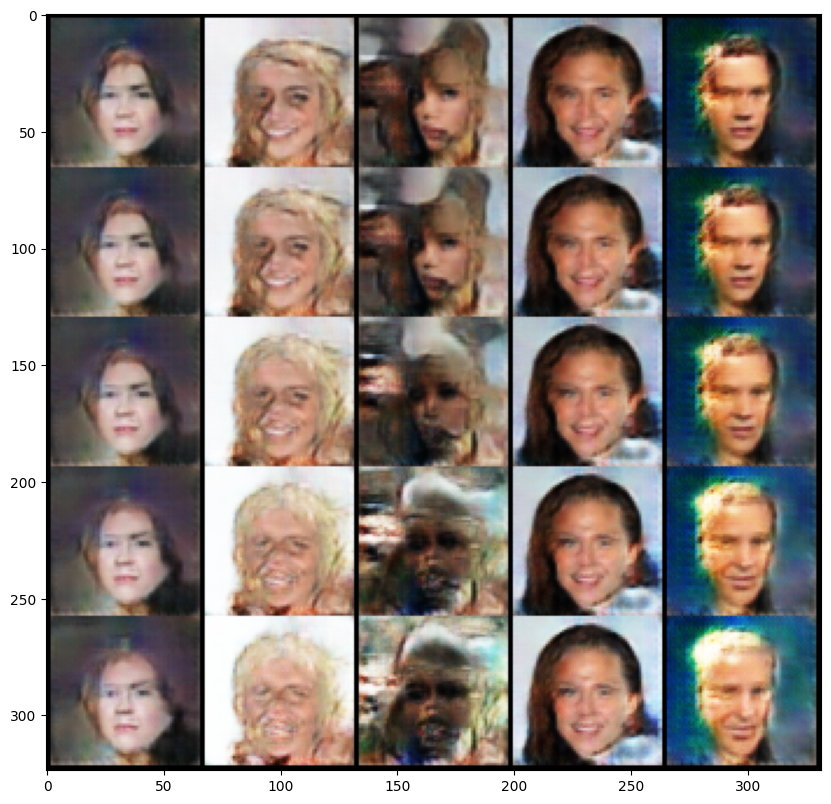

In [13]:
# First generate a bunch of images with the generator
n_images = 5
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male",
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose",
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings",
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

target_indices = feature_names.index("GrayHair") # Feel free to change this value to any string from feature_names!

noise = get_noise(n_images, z_dim).to(device).requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_classes_score = classifier(fake)[:, target_indices].mean()
    fake_classes_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

## Управляемая генерация с L2-нормой

In [14]:
def get_score(current_classifications, original_classifications, target_indices, other_indices, penalty_weight):
    '''
    Function to return the score of the current classifications, penalizing changes
    to other classes with an L2 norm.
    Parameters:
        current_classifications: the classifications associated with the current noise
        original_classifications: the classifications associated with the original noise
        target_indices: the index of the target class
        other_indices: the indices of the other classes
        penalty_weight: the amount that the penalty should be weighted in the overall score
    '''
    # Steps: 1) Calculate the change between the original and current classifications (as a tensor)
    #           by indexing into the other_indices you're trying to preserve, like in x[:, features].
    #        2) Calculate the norm (magnitude) of changes per example.
    #        3) Multiply the mean of the example norms by the penalty weight.
    #           This will be your other_class_penalty.
    #           Make sure to negate the value since it's a penalty!
    #        4) Take the mean of the current classifications for the target feature over all the examples.
    #           This mean will be your target_score.
    other_distances = current_classifications[:,other_indices] - original_classifications[:,other_indices]
    # Calculate the norm (magnitude) of changes per example and multiply by penalty weight
    other_class_penalty = -torch.norm(other_distances, dim=1).mean() * penalty_weight
    # Take the mean of the current classifications for the target feature
    target_score = current_classifications[:, target_indices].mean()
    return target_score + other_class_penalty

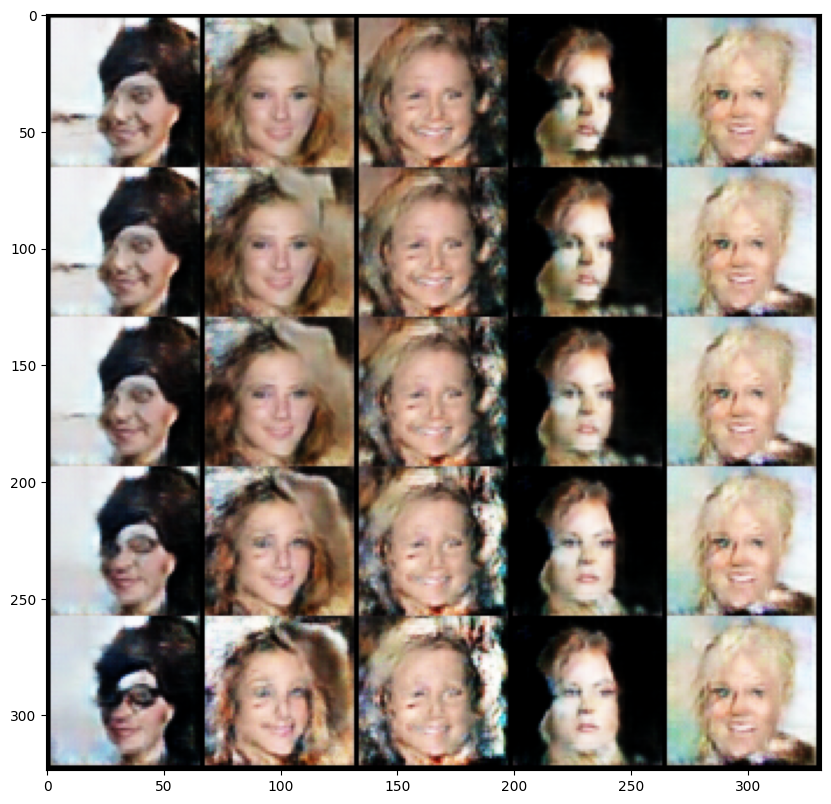

In [15]:
fake_image_history = []
target_indices = feature_names.index("Eyeglasses") # Feel free to change this value to any string from feature_names from earlier!
other_indices = [cur_idx != target_indices for cur_idx, _ in enumerate(feature_names)]
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
original_classifications = classifier(gen(noise)).detach()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_score = get_score(
        classifier(fake),
        original_classifications,
        target_indices,
        other_indices,
        penalty_weight=0.2
    )
    fake_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

# Video Generation

В этом раздел мы разберем TGAN, из статьи [Temporal Generative Adversarial Nets with Singular Value Clipping](https://arxiv.org/abs/1611.06624) (Saito, Matsumoto, & Saito, 2017). 

1. **Два генератора** TGAN - это первая работа в области генерации видео, в которой используются два различных генератора : временной генератор (Temporal Generator) и генератор изображений. Временной генератор генерирует временные латентные векторы $\vec{z}_t$s, которые преобразуются генератором изображений $G_i$. В последующих работах использовались аналогичные подходы.


2. **Создан Inception Score Benchmark** В то время наиболее распространенным методом количественного сравнения был Inception Score (IS). Для GAN, обученного на ImageNet, для расчета IS необходима предварительно обученная модель Inception. Для видео не существовало модели, сопоставимой с Inception, поэтому авторы предложили использовать модель C3D, обученную на наборе данных UCF101. Используя эту предварительно обученную модель, они создали общий метод расчета IS для генерации видео.


3. **Singular Value Clipping (SVC)** Чтобы обеспечить ограничение 1-Липшица на дискриминатор, авторы предлагают обрезать сингулярные значения на конволюционном и линейном слоях. Через каждые 5 эпох они выполняют [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) для весов матрицы они применяют следующий алгоритм: <br /> $\begin{gather}U \Sigma V^* = W \\ \Sigma_{ii} := \min(\Sigma_{ii}, 1) \\ W := U \Sigma V^* \end{gather}$ <br /> В своих экспериментах они показали, что TGAN, обученный с помощью SVC, превосходит обычную GAN.

## Архитектура

Видеогенератор состоит из двух генераторов - временного и генератора изображения. Временной генератор временной генератор $G_0$ формирует набор латентных переменных (шума) $z_t^1(t = 1, . . . , T )$ из $z_0$. Генератор изображения $G+1$ преобразует эти латентные переменные $z_t^1(t = 1, . . . , T )$ и $z_0$ в видеоданные, состоящие из $T$ кадров. Дискриминатор состоит из трехмерных конволюционных слоев, и оценивает, являются ли эти кадры из набора данных или из генератора видео. Форма тензора в дискриминаторе обозначается как "(каналы)×(время)×(высота)×(ширина)".
![tgan](./data/tgan.png)

In [16]:
import torch
import torch.nn as nn
import numpy as np
from moviepy.editor import ImageSequenceClip
from IPython.display import Image

def genSamples(g, n=8):
    '''
    Generate an n by n grid of videos, given a generator g
    '''
    with torch.no_grad():
        s = g(torch.rand((n**2, 100), device='cuda')*2-1).cpu().detach().numpy()

    out = np.zeros((3, 16, 64*n, 64*n))

    for j in range(n):
        for k in range(n):
            out[:, :, 64*j:64*(j+1), 64*k:64*(k+1)] = s[j*n+k, :, :, :, :]


    out = out.transpose((1, 2, 3, 0))
    out = (out + 1) / 2 * 255
    out = out.astype(int)
    clip = ImageSequenceClip(list(out), fps=20)
    clip.write_gif('sample.gif', fps=20)

## Как генерировать видео
Первое, что следует отметить при генерации видео, - это то, что теперь мы генерируем тензоры с дополнительным измерением. В то время как обычные методы работы с изображениями позволяют генерировать тензоры в $\mathbb{R}^{C \times H \times W}$, теперь мы генерируем тензоры размера $\mathbb{R}^{T \times C \times H \times W}$.

Для решения этой проблемы TGAN предложил сначала генерировать временную динамику, а затем генерировать изображения. В работе Gordon и Parde, 2020 есть визуальное представление, которое обобщает процесс работы генератора.

![generator](https://imgur.com/vH8cakL.png)

Латентный вектор $\vec{z}_c$ выбирается из распределения. Этот вектор поступает в некоторый генератор $G_t$, который преобразует вектор в серию латентных временных векторов. $G_t:\vec{z}_c \mapsto \{\vec{z}_0, \vec{z}_1, \dots, \vec{z}_t\}$ Отсюда каждый временной вектор соединяется с $\vec{z}_c$ и подается в генератор изображений $G_i$. После того как все изображения созданы, на последнем этапе мы объединяем их в видеоролик. Таким образом, мы декомпозируем время и изображения.

Сегодня мы попытаемся представить набор данных UCF101. Этот набор данных состоит из 101 класса действий. Ниже приведена выборка реальных примеров:

![gif grid](https://imgur.com/9Cp5868.gif)

## Временной генератор $G_t$
Здесь мы будем реализовывать наш временной генератор. Он преобразует вектор в $\mathbb{R}^{100}$ 16 векторов в $\mathbb{R}^{100}$. В TGAN использовалась серия транспонированных одномерных сверток.

In [18]:
class TemporalGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # Create a sequential model to turn one vector into 16
        self.model = nn.Sequential(
            nn.ConvTranspose1d(100, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 100, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

        # initialize weights according to paper
        self.model.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.ConvTranspose1d:
            nn.init.xavier_uniform_(m.weight, gain=2**0.5)

    def forward(self, x):
        # reshape x so that it can have convolutions done
        x = x.view(-1, 100, 1)
        # apply the model and flip the
        x = self.model(x).transpose(1, 2)
        return x

## Собираем все вместе

Когда $\vec{z}_c$ сгенерирован, а временные векторы созданы, пришло время генерировать отдельные изображения. Первым шагом является преобразование двух векторов в соответствующие размеры для подачи в транспонированное двумерное конволюционное ядро. Это делается с помощью линейного преобразования с нелинейностью. Каждый вновь преобразованный вектор перестраивается в тензор $\mathbb{R}^{256 \times 4 \times 4}$. В этой форме два набора векторов конкатенируются по размерности канала.

После преобразования, переформирования и конкатенации векторов наконец-то наступает время создания изображений! В TGAN используется общий генератор изображений, состоящий из множества транспонированных двумерных сверток. После достаточного количества транспонированных сверток, батч-норм и ReLU последние две операции - транспонированная свертка в 3 цветовых канала и активация $\tanh$. Последний шаг - изменение формы, чтобы тензор имел размерность по времени, цветовому каналу, высоте и ширине. Теперь у нас есть видео!

In [29]:
class VideoGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # instantiate the temporal generator
        self.temp = TemporalGenerator()

        # create a transformation for the temporal vectors
        self.fast = nn.Sequential(
            nn.Linear(100, 256 * 4**2, bias=False),
            nn.BatchNorm1d(256 * 4**2),
            nn.ReLU()
        )

        # create a transformation for the content vector
        self.slow = nn.Sequential(
            nn.Linear(100, 256 * 4**2, bias=False),
            nn.BatchNorm1d(256 * 4**2),
            nn.ReLU()
        )


        # define the image generator
        self.model = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

        # initialize weights according to the paper
        self.fast.apply(self.init_weights)
        self.slow.apply(self.init_weights)
        self.model.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.ConvTranspose2d or type(m) == nn.Linear:
            nn.init.uniform_(m.weight, a=-0.01, b=0.01)

    def forward(self, x):
        # pass our latent vector through the temporal generator and reshape
        z_fast = self.temp(x).contiguous()
        z_fast = z_fast.view(-1, 100)

        # transform the content and temporal vectors
        z_fast = self.fast(z_fast).view(-1, 256, 4, 4)
        z_slow = self.slow(x).view(-1, 256, 4, 4).unsqueeze(1)
        # after z_slow is transformed and expanded we can duplicate it
        z_slow = torch.cat([z_slow]*16, dim=1).view(-1, 256, 4, 4)

        # concatenate the temporal and content vectors
        z = torch.cat([z_slow, z_fast], dim=1)

        # transform into image frames
        out = self.model(z)

        return out.view(-1, 16, 3, 64, 64).transpose(1, 2)

### The Discriminator

Мы больше не оперируем изображениями, поэтому теперь нам необходимо переосмыслить наш дискриминатор. Двумерные свертки не работают из-за временного измерения, что же делать? TGAN предлагает дискриминатор, состоящий из серии 3D-сверток и одной 2D-свертки. Из одного видеоролика он выдает одно целое число.

```python
class VideoDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model3d = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=4, padding=1, stride=2),
            nn.LeakyReLU(0.2),
            nn.Conv3d(64, 128, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2),
            nn.Conv3d(128, 256, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2),
            nn.Conv3d(256, 512, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm3d(512),
            nn.LeakyReLU(0.2)
        )

        self.conv2d = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)

        # initialize weights according to paper
        self.model3d.apply(self.init_weights)
        self.init_weights(self.conv2d)

    def init_weights(self, m):
        if type(m) == nn.Conv3d or type(m) == nn.Conv2d:
            nn.init.xavier_normal_(m.weight, gain=2**0.5)

    def forward(self, x):
        h = self.model3d(x)
        # turn a tensor of R^NxTxCxHxW into R^NxCxHxW
        h = torch.reshape(h, (32, 512, 4, 4))
        h = self.conv2d(h)
        return h
```
После того как наш дискриминатор выполнит вывод на некоторых выборках, полученные целые числа будут использованы в формулировке WGAN (подробнее об этом вы узнаете на следующей неделе!):

$$\operatorname*{argmax}_D \operatorname*{argmin}_G\mathbb{E}_{x\sim \mathbb{P}_r}[D(x)]-\mathbb{E}_{z\sim p(z)}[D(G(z))]$$.

В процессе обучения это выглядит следующим образом.

```python
# update discriminator
pr = dis(real)
fake = gen(torch.rand((batch_size, 100), device='cuda')*2-1)
pf = dis(fake)
dis_loss = torch.mean(-pr) + torch.mean(pf)
dis_loss.backward()
disOpt.step()

# update generator
genOpt.zero_grad()
fake = gen(torch.rand((batch_size, 100), device='cuda')*2-1)
pf = dis(fake)
gen_loss = torch.mean(-pf)
gen_loss.backward()
genOpt.step()
```


In [30]:
# instantiate the generator, load the weights, and create a sample
gen = VideoGenerator().cuda()
gen.load_state_dict(torch.load('./data/state_normal81000.ckpt')['model_state_dict'][0])
genSamples(gen)

MoviePy - Building file sample.gif with imageio.


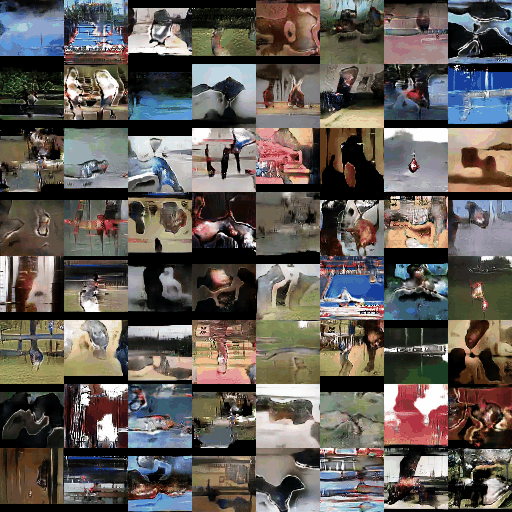

In [31]:
# Run this cell to see results!
Image(open('sample.gif', 'rb').read())

## Дополнительная информация о SVC

SVC хорошо зарекомендовал себя в оригинальной статье TGAN, и его усовершенствования были повторены. Ограничение дискриминатора функцией 1-Липшица стабилизирует обучение. На приведенном ниже графике сравнивается время обучения и оценка IS между TGAN, обученным с использованием SVC и без него.

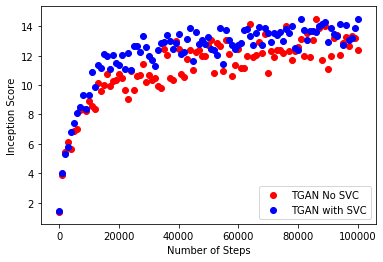

Чтобы обеспечить выполнение ограничения 1-Липшица на дискриминаторе, в процессе обучения необходимо вносить определенные изменения в параметры. В TGAN приводится полезный рисунок, поясняющий, что и как нужно ограничивать в каждом параметре.

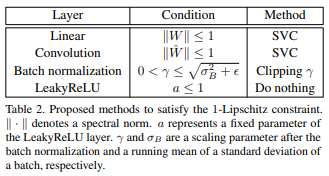

Следующий код/псевдокод объясняет, как это сделать в PyTorch.

1. Определяем как будет клипать веса матрицы

```python
def singular_value_clip(w):
    dim = w.shape
    # reshape into matrix if not already MxN
    if len(dim) > 2:
        w = w.reshape(dim[0], -1)
    u, s, v = torch.svd(w, some=True)
    s[s > 1] = 1
    return (u @ torch.diag(s) @ v.t()).view(dim)
```

2. После обновления весов в процессе обучения измените слои, чтобы обеспечить соблюдение ограничений.

```python
for iteration in range(steps):
    # update generator and discriminator weights
    # enfore 1-Lipschitz
    if iteration % 5 == 0:
        for module in list(dis.model3d.children()) + [dis.conv2d]:
            if type(module) == nn.Conv3d or type(module) == nn.Conv2d:
                module.weight.data = singular_value_clip(module.weight)
            elif type(module) == nn.BatchNorm3d:
                gamma = module.weight.data
                std = torch.sqrt(module.running_var)
                gamma[gamma > std] = std[gamma > std]
                gamma[gamma < 0.01 * std] = 0.01 * std[gamma < 0.01 * std]
                module.weight.data = gamma
```
